In [1]:
import numpy as np

In [2]:
# 단순한 계층 구현
# 곱셉노드
class MulLayer:
    def __init__(self): #초기화
        self.x=None
        self.y=None
    
    def forword(self, x, y): # x,y를 받아서 곱함
        self.x = x
        self.y = y
        out= x*y
        
        return out
    
    def backword(self, dout): # 상류에서 넘어온 미분(dout)에 순전파 때의 값을 서로 바꿔 곱한 후 하류로 흘림
        dx= dout * self.y # x 와 y를 바꾼다 -> 편미분시 남는 변수가 달라짐
        dy= dout * self.x
        
        return dx, dy

apple = 100
apple_num=2
tax = 1.1

# 계층들
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#순전파
apple_price = mul_apple_layer.forword(apple, apple_num)
price = mul_tax_layer.forword(apple_price, tax)

print(price)

# 역전파
dprice = 1
dapple_price, dtax = mul_tax_layer.backword(dprice)
dapple, dapple_num = mul_apple_layer.backword(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [3]:
# 덧셈노드
class AddLayer:
    def __init__(self): # 덧셈계층은 초기화 필요 없음
        pass#아무것도 하지말라
    
    def forword(self, x ,y): # x, y 더해서 반환 
        out = x + y
        return out
    
    def backword(self, dout): # 상류에서 내려온 미분(dout)을 그대로 하류로 흘림
        dx = dout * 1 
        dy = dout * 1
        return dx, dy
    


In [4]:
apple = 100
apple_num=2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
mul_tax_layer = MulLayer()

add_apple_orange = AddLayer()

# 순전파
apple_price = mul_apple_layer.forword(apple, apple_num)
orange_price = mul_orange_layer.forword(orange,orange_num)

all_price = add_apple_orange.forword(apple_price, orange_price)

price = mul_tax_layer.forword(all_price, tax)
#print(apple_price, orange_price, all_price, price)

# 역전파
dprice = 1
dall_price, dtax= mul_tax_layer.backword(dprice)
dapple_price, dorange_price = add_apple_orange.backword(dall_price)
dorange, dorange_num = mul_orange_layer.backword(dorange_price)
dapple, dapple_num = mul_apple_layer.backword(dapple_price)

print(price)
print(dapple_num,dapple, dorange_num,dorange, dtax)

715.0000000000001
110.00000000000001 2.2 165.0 3.3000000000000003 650


In [5]:
#ReLU 구현
# forword 와 backword 의 인자 x, dout은 넘파이 배열로 받는 것으로 가정
class Relu:
    def __init__(self):
        self.mask = None # T/F로 구성된 넘파이 배열
    
    def forword(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backword(self,dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [21]:
# sigmoid 구현
class sigmoid:
    def __init__(self):
        self.out = None
    
    def forword(self,x):
        out = 1/ (1+np.exp(-x))
        self.out= out
        
        return out
    
    def backword(self, dout):
        dx = dout*(1.0 - self.out) * self.out # forword의 out을 저장해뒀다가 역전파 계산에 사용
        
        return dx

In [26]:
# Affine(행렬의 곱 신경망) 구현
# 책
class Affine:
    def __init__(self,W,b):
        self.W=W
        self.b=b
        self.x=None
        self.dW=None
        self.db=None
    
    def forword(self, x):
        self.x=x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backword(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx
# 예제 코드 for 텐서대응
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


In [23]:
# softmax with loss 구현 ( softmax + cross entropy)
def softmax(a):
    c=np.max(a) #오버플로 대책
    exp_a=np.exp(a-c)
    sum_exp_a=np.sum(exp_a)
    y=exp_a/sum_exp_a
    return y
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t=t.reshape(1,t.size)   # reshape(행,열) 
        y=t.reshape(1,y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+ 1e-7)) / batch_size # y[np.arange(batch_size),t] => y[0,3], y[1,2], y[2,5]...


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax 출력
        self.t = None # 정답 레이블(원핫 벡터)
    
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.x = x
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backword(self,dout=1):
        batxh_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

array([[2, 0],
       [2, 0]])

In [34]:
# 오차역전파법을 적용한 신경망 클래스 구현
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict # 순서가 있는 dict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x) # 각 layer의 forword
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t): # 수치미분법으로 기울기 구하기
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t): # 오차역적파법으로 기울기 구하기
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [35]:
# 기울기 확인 ( 수치미분 과 거의 같음을 확인 )
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:4.678205826238631e-10
b1:2.6840044131556897e-09
W2:5.572674338134994e-09
b2:1.392507400443943e-07


In [36]:
# 오차역전파법을 사용한 학습 구현

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.10608333333333334 0.1044
0.8991 0.9009
0.9222666666666667 0.926
0.9352166666666667 0.9314
0.94335 0.943
0.9498333333333333 0.9463
0.9545833333333333 0.9523
0.9600333333333333 0.956
0.9630166666666666 0.958
0.9654333333333334 0.9602
0.9687 0.9634
0.9705666666666667 0.9652
0.9721833333333333 0.9658
0.974 0.9681
0.975 0.9678
0.9758166666666667 0.9692
0.9788333333333333 0.9704


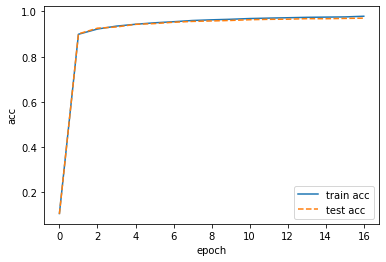

In [42]:
# 그래프 시각화
import matplotlib.pylab as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))

plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend(loc='lower right')
plt.show()